In [2]:
import pymc3 as pm
import warnings
warnings.filterwarnings('ignore')

In [151]:
import theano
import theano.tensor as tt
import arviz as az

In [140]:
import pandas as pd
import numpy as np
import math
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import mquantiles
from plotnine import *

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from prophet import Prophet
from scipy import optimize

In [3]:
data = pd.read_csv(
  'https://raw.githubusercontent.com/haensel-ams/recruitment_challenge/master/DataScience_202209/MMM_test_data.csv',
  parse_dates=['start_of_week'],
  index_col='start_of_week'
)

X = data.drop(columns=['revenue'])
y = data['revenue']

In [47]:
data.head()

,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
start_of_week,,,,,,,,
2020-08-30,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79
2020-06-09,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45
2020-09-13,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05
2020-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73
2020-09-27,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48


In [48]:
data.tail()

,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
start_of_week,,,,,,,,
2022-07-24,72021.50,0.0,1118.78,22305.10,4566.01,2987.70,0.0,19916.88
2022-07-31,90786.21,0.0,122.16,15812.65,4795.51,3293.40,0.0,22687.98
2022-07-08,105929.40,0.0,754.09,12166.85,4961.12,4057.03,0.0,30142.64
2022-08-14,90506.31,0.0,1043.22,10856.58,4431.13,3086.81,0.0,28622.78
2022-08-21,84394.50,0.0,387.94,10757.63,4693.41,2972.11,0.0,30547.18


In [129]:
def adstock_geometric(x: float, alpha: float):
    x_decayed = np.zeros_like(x)
    x_decayed[0] = x[0]
    for xi in range(1, len(x_decayed)):
        x_decayed[xi] = x[xi] + alpha* x_decayed[xi - 1]
    return x_decayed

In [130]:
def adstock_geometric_theano_pymc3(x, theta):
    x = tt.as_tensor_variable(x)
    
    def adstock_geometric_recurrence_theano(index, 
                                            input_x, 
                                            decay_x,   
                                            theta):
        return tt.set_subtensor(decay_x[index], 
               tt.sum(input_x + theta * decay_x[index - 1]))
    len_observed = x.shape[0]
    x_decayed = tt.zeros_like(x)
    x_decayed = tt.set_subtensor(x_decayed[0], x[0])
    output, _ = theano.scan(
        fn = adstock_geometric_recurrence_theano, 
        sequences = [tt.arange(1, len_observed), x[1:len_observed]], 
        outputs_info = x_decayed,
        non_sequences = theta, 
        n_steps = len_observed - 1
    )
    
    return output[-1]

In [132]:
def saturation_hill_pymc3(x, alpha, gamma): 
    x_s_hill = x ** alpha / (x ** alpha + gamma ** alpha)
    return x_s_hill

In [31]:
# Python
from prophet import Prophet
holidays=pd.DataFrame(columns=['ds', 'holiday'])
type(holidays)
m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='DE')
#m.fit(df)

In [34]:
m.holidays

,ds,holiday


In [35]:
!pip install holidays

In [81]:
import holidays
holidays.country_holidays('DE', years=[2020,2021,2022]).values()

dict_values(['Neujahr', 'Karfreitag', 'Ostermontag', 'Erster Mai', 'Christi Himmelfahrt', 'Pfingstmontag', 'Tag der Deutschen Einheit', 'Erster Weihnachtstag', 'Zweiter Weihnachtstag', 'Neujahr', 'Karfreitag', 'Ostermontag', 'Erster Mai', 'Christi Himmelfahrt', 'Pfingstmontag', 'Tag der Deutschen Einheit', 'Erster Weihnachtstag', 'Zweiter Weihnachtstag', 'Neujahr', 'Karfreitag', 'Ostermontag', 'Erster Mai', 'Christi Himmelfahrt', 'Pfingstmontag', 'Tag der Deutschen Einheit', 'Erster Weihnachtstag', 'Zweiter Weihnachtstag'])

In [89]:
d = holidays.country_holidays('DE', years=[2020,2021,2022])

In [91]:
df = pd.DataFrame(d.items(), columns=['ds', 'holiday'])

In [93]:
# import holidays
# hol = ((date, 1) for date in holidays.country_holidays('DE', years=[2020,2021,2022]))
# df = pd.DataFrame(hol, columns =['date', 'holiday'])
# df.tail(3)

In [94]:
holidays_weekly_de = df.copy()
holidays_weekly_de['ds']=holidays_weekly_de['ds'].astype('datetime64')
holidays_weekly_de["begin_week"] = holidays_weekly_de["ds"].dt.to_period('W-SUN').dt.start_time
# holidays_weekly_de.drop(['date'], axis=1, inplace=True)
holidays_weekly_de.head()

,ds,holiday,begin_week
0,2020-01-01,Neujahr,2019-12-30
1,2020-04-10,Karfreitag,2020-04-06
2,2020-04-13,Ostermontag,2020-04-13
3,2020-05-01,Erster Mai,2020-04-27
4,2020-05-21,Christi Himmelfahrt,2020-05-18


### Fit Prophet on our data, including holidays, a categorical variable, and using yearly seasonality

In [66]:
prophet_data = data.rename(columns = {'revenue': 'y'})
prophet_data['ds'] = prophet_data.index
prophet_data.head()

,y,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7,ds
start_of_week,,,,,,,,,
2020-08-30,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79,2020-08-30
2020-06-09,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45,2020-06-09
2020-09-13,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05,2020-09-13
2020-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73,2020-09-20
2020-09-27,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48,2020-09-27


19:08:03 - cmdstanpy - INFO - Chain [1] start processing
19:08:03 - cmdstanpy - INFO - Chain [1] done processing


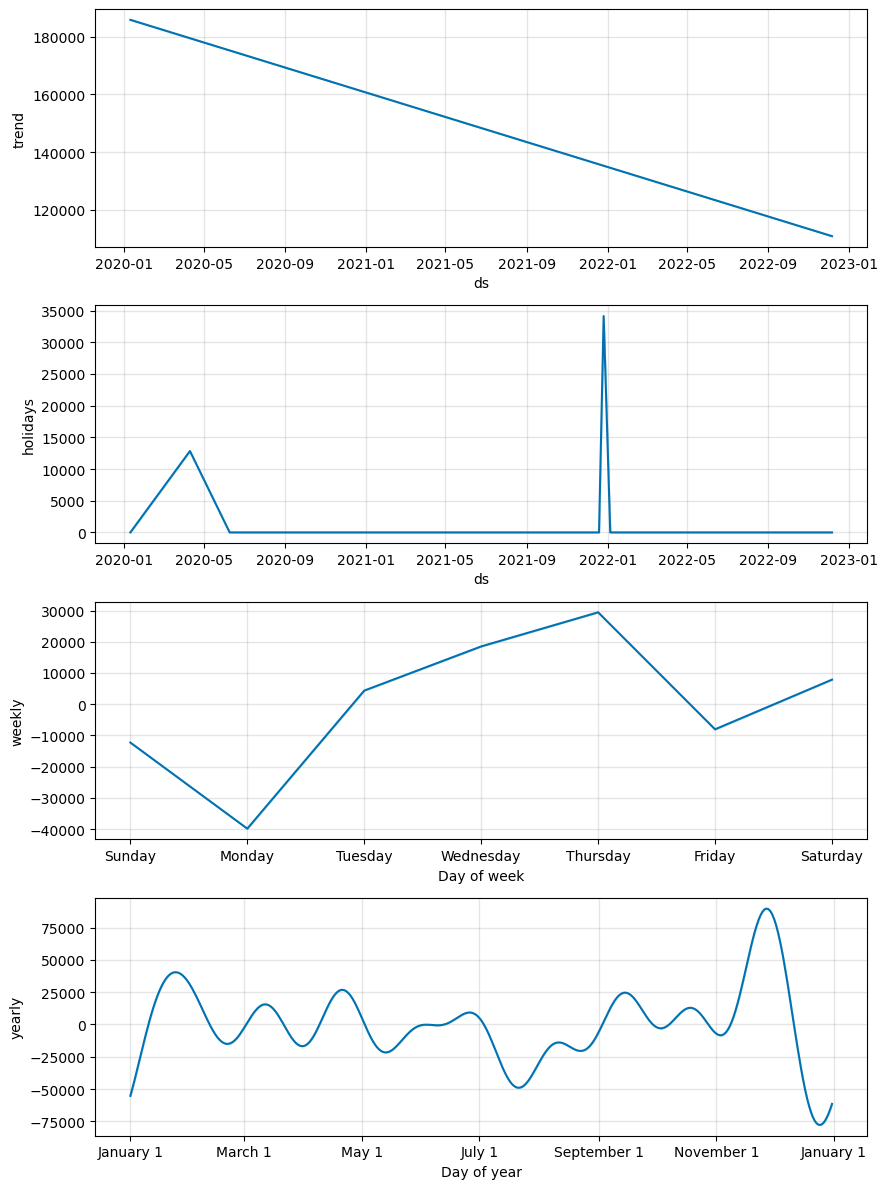

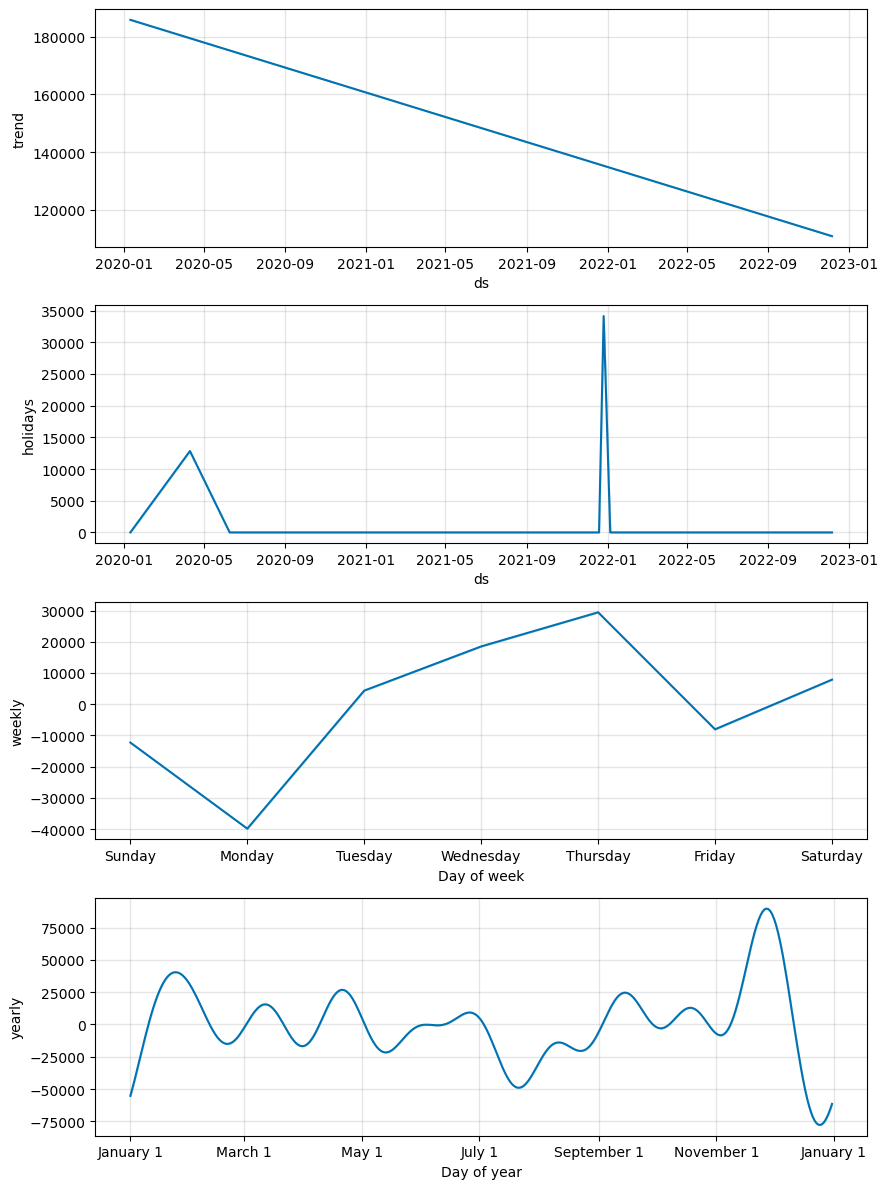

In [98]:
prophet = Prophet( holidays=holidays_weekly_de,  yearly_seasonality=True)

prophet.fit(prophet_data[["ds", "y"]])
prophet_predict = prophet.predict(prophet_data[["ds", "y"]])
prophet.plot_components(prophet_predict)

In [104]:
prophet_predict[['trend','yearly','holidays']].head()

,trend,yearly,holidays
0,185848.300068,-691.632640,0.00000
1,179487.010606,3595.447529,12835.14365
2,175246.150966,-671.281567,0.00000
3,175034.107984,-227.590944,0.00000
4,170793.248255,-13912.201182,0.00000


In [115]:
final_data = data.copy()
final_data = final_data.reset_index(drop=False)
final_data["trend"] = prophet_predict["trend"]
final_data["season"] = prophet_predict["yearly"]
final_data["holiday"] = prophet_predict["holidays"]
final_data.head()

,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7,trend,season,holiday
0,2020-08-30,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79,185848.300068,-691.632640,0.00000
1,2020-06-09,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45,179487.010606,3595.447529,12835.14365
2,2020-09-13,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05,175246.150966,-671.281567,0.00000
3,2020-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73,175034.107984,-227.590944,0.00000
4,2020-09-27,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48,170793.248255,-13912.201182,0.00000


In [116]:
final_data.columns

Index(['start_of_week', 'revenue', 'spend_channel_1', 'spend_channel_2',
       'spend_channel_3', 'spend_channel_4', 'spend_channel_5',
       'spend_channel_6', 'spend_channel_7', 'trend', 'season', 'holiday'],
      dtype='object')

In [117]:
data1 = final_data.copy()
transform_variables = ['spend_channel_1', 'spend_channel_2', 'spend_channel_3',
       'spend_channel_4', 'spend_channel_5', 'spend_channel_6',
       'spend_channel_7', 'trend', 'season', 'holiday']
delay_channels = ['spend_channel_1', 'spend_channel_2', 'spend_channel_3',
       'spend_channel_4', 'spend_channel_5', 'spend_channel_6',
       'spend_channel_7']
media_channels = ['spend_channel_1', 'spend_channel_2', 'spend_channel_3',
       'spend_channel_4', 'spend_channel_5', 'spend_channel_6',
       'spend_channel_7']
control_variables = ["trend", "season", "holiday"]
target = "revenue"

In [118]:
data1.head()

,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7,trend,season,holiday
0,2020-08-30,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79,185848.300068,-691.632640,0.00000
1,2020-06-09,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45,179487.010606,3595.447529,12835.14365
2,2020-09-13,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05,175246.150966,-671.281567,0.00000
3,2020-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73,175034.107984,-227.590944,0.00000
4,2020-09-27,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48,170793.248255,-13912.201182,0.00000


In [121]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
data1[transform_variables] = scaler.fit_transform(data1[transform_variables])
data1[target]=data1[target]/data1[target].mean()
data1.head()

,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7,trend,season,holiday
0,2020-08-30,1.156909,0.308378,0.161313,0.160361,0.000390,0.378394,0.375721,0.146681,1.000000,0.458945,0.000000
1,2020-06-09,1.365854,0.309380,0.065121,0.064504,0.050369,0.371960,0.366196,0.192111,0.915094,0.484744,0.376055
2,2020-09-13,1.184022,0.245140,0.066158,0.027823,0.039982,0.442250,0.320874,0.193912,0.858489,0.459067,0.000000
3,2020-09-20,1.319429,0.198583,0.030235,0.211356,0.014779,0.457934,0.382581,0.225230,0.855659,0.461737,0.000000
4,2020-09-27,1.595675,0.181740,0.047575,0.287670,0.023171,0.466375,0.375230,0.251468,0.799055,0.379386,0.000000


In [141]:
response_mean = []
with pm.Model() as model_2:
    for channel_name in delay_channels:
        print(f"Delay Channels: Adding {channel_name}")
        
        x = data1[channel_name].values
        
        adstock_param = pm.Beta(f"{channel_name}_adstock", 4, 4)
        saturation_gamma = pm.Beta(f"{channel_name}_gamma", 3, 3)
        saturation_alpha = pm.Gamma(f"{channel_name}_alpha", 2, 3)
        
        x_new = adstock_geometric_theano_pymc3(x, adstock_param)
        
        saturation_tensor = saturation_hill_pymc3(x_new, saturation_alpha, saturation_gamma)
        
        channel_b = pm.HalfNormal(f"{channel_name}_media_coef", sd = 3)
        response_mean.append(saturation_tensor * channel_b)
        
    for control_var in control_variables:
        print(f"Control Variables: Adding {control_var}")
        
        x = data1[control_var].values
        
        control_beta = pm.Normal(f"{control_var}_control_coef", sd = 3)
        control_x = control_beta * x
        response_mean.append(control_x)
        
    intercept = pm.Normal("intercept", np.mean(data1[target].values), sd = 3)
    #intercept = pm.HalfNormal("intercept", 0, sd = 3)
        
    sigma = pm.HalfNormal("sigma", 4)
    
    likelihood = pm.Normal("outcome", mu = intercept + sum(response_mean), sd = sigma, observed = data1[target].values)

Delay Channels: Adding spend_channel_1
Delay Channels: Adding spend_channel_2
Delay Channels: Adding spend_channel_3
Delay Channels: Adding spend_channel_4
Delay Channels: Adding spend_channel_5
Delay Channels: Adding spend_channel_6
Delay Channels: Adding spend_channel_7
Control Variables: Adding trend
Control Variables: Adding season
Control Variables: Adding holiday


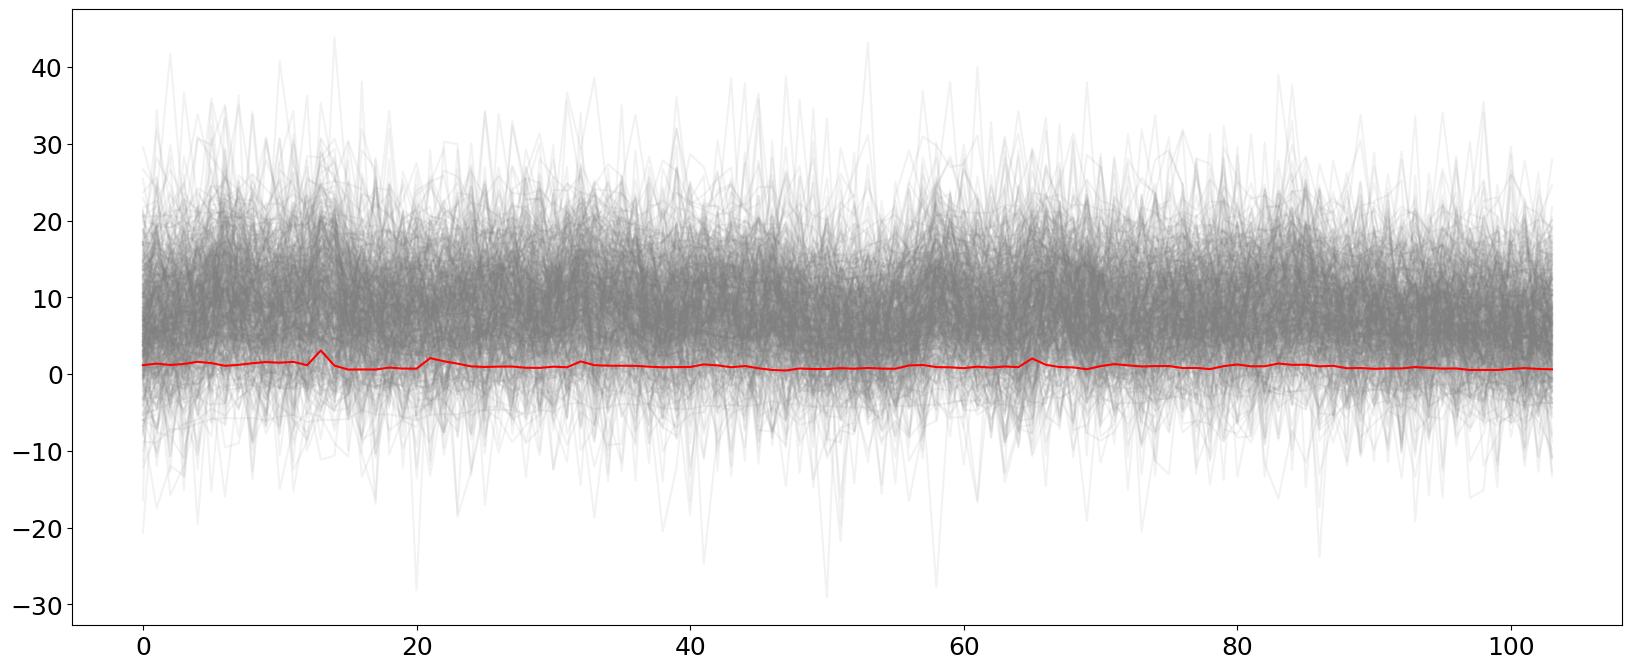

In [143]:
with model_2:
    prior_pred = pm.sample_prior_predictive()
    
fig, ax = plt.subplots(figsize = (20, 8))
_ = ax.plot(prior_pred["outcome"].T, color = "0.5", alpha = 0.1)
_ = ax.plot(data1[target].values, color = "red")

In [145]:
prior_names = [prior_name for prior_name in list(prior_pred.keys()) if (prior_name.endswith("logodds__") == False) & (prior_name.endswith("_log__") == False)]


In [146]:

len(prior_names)

34

In [148]:
#plots priors using the random variables
def plot_priors(variables, prior_dictionary = None):
    if isinstance(variables[0], pm.model.TransformedRV) == False and prior_dictionary is None:
        raise Exception("prior dictionary should be provided. It can be generated by sample_prior_predictive")
    cols = 2
    rows = int(math.ceil(len(variables)/cols))
    fig, ax = plt.subplots(rows, cols, figsize=(15, 3*rows))
    ax = np.reshape(ax, (-1, cols))
    for i in range(rows):
         for j in range(cols):
            vi = i*cols + j
            if vi < len(variables):
                var = variables[vi]
                if isinstance(var, pm.model.TransformedRV):
                    sns.histplot(var.random(size=10000).flatten(), kde=True, ax=ax[i, j])
                    #p.set_axis_labels(var.name)
                    ax[i, j].set_title(var.name)
                else:
                    prior = prior_dictionary[var]
                    sns.histplot(prior, kde=True, ax = ax[i, j])
                    ax[i, j].set_title(var)
    plt.tight_layout()

adstock priors: 7
alpha priors: 7
gamma priors: 7
media coef priors: 7
control coef priors: 4
sigma prior: 1


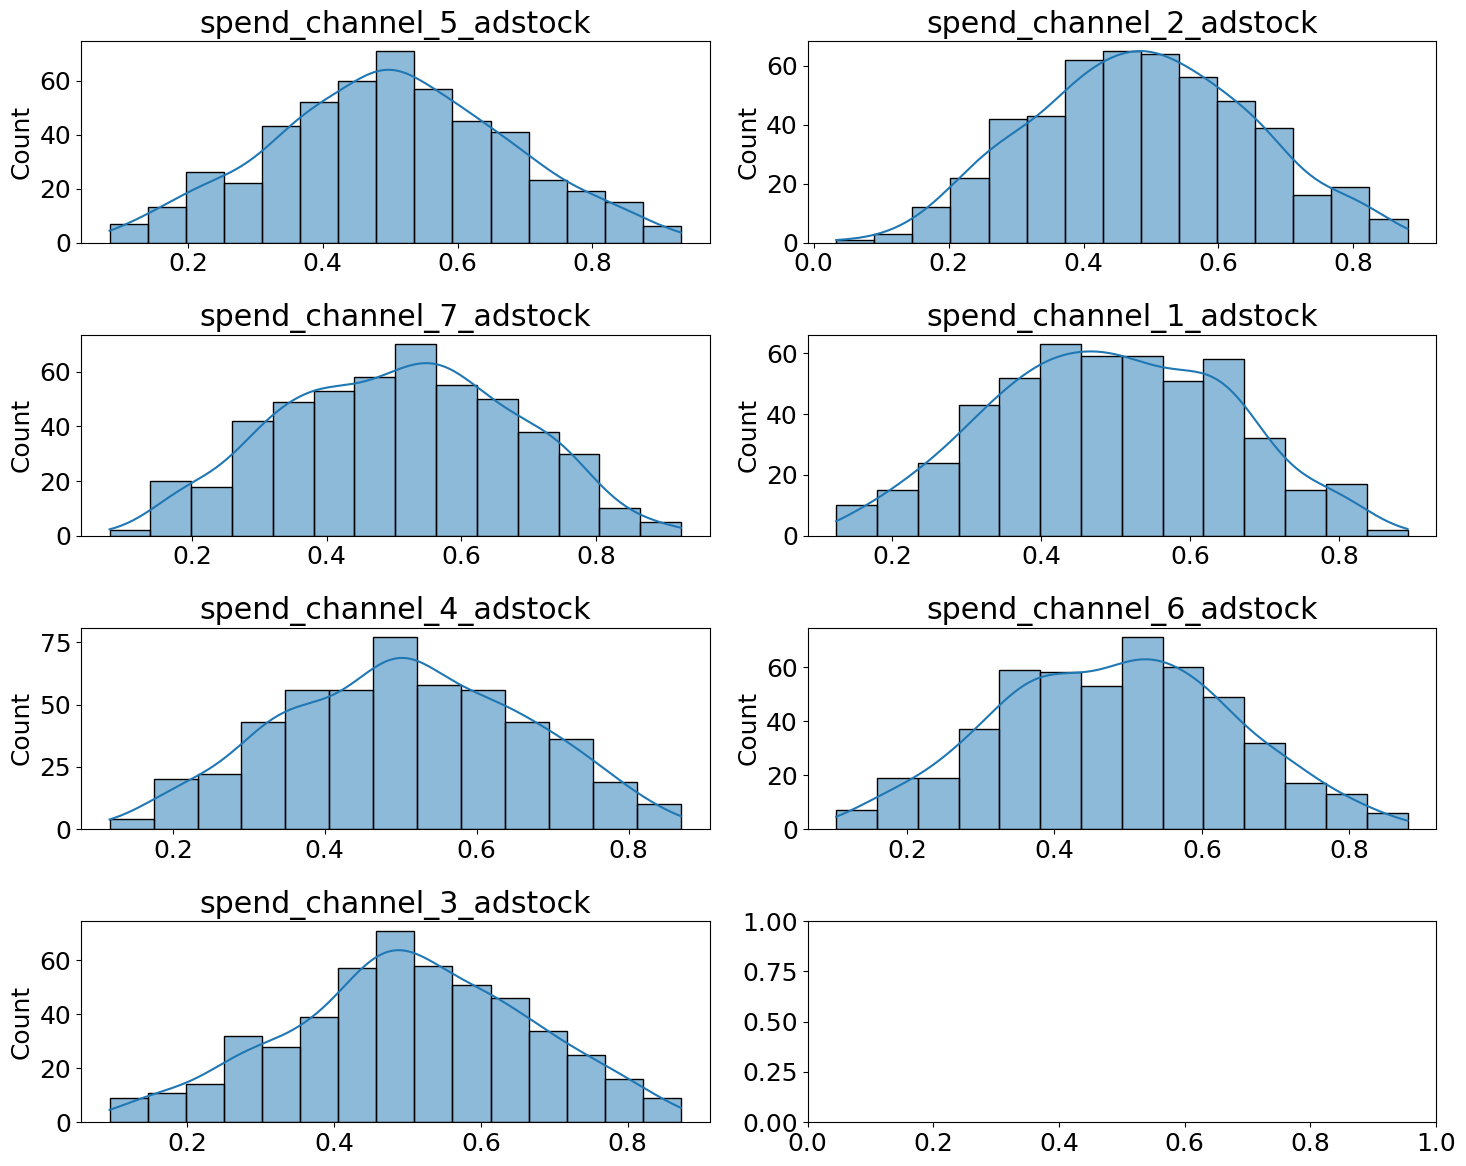

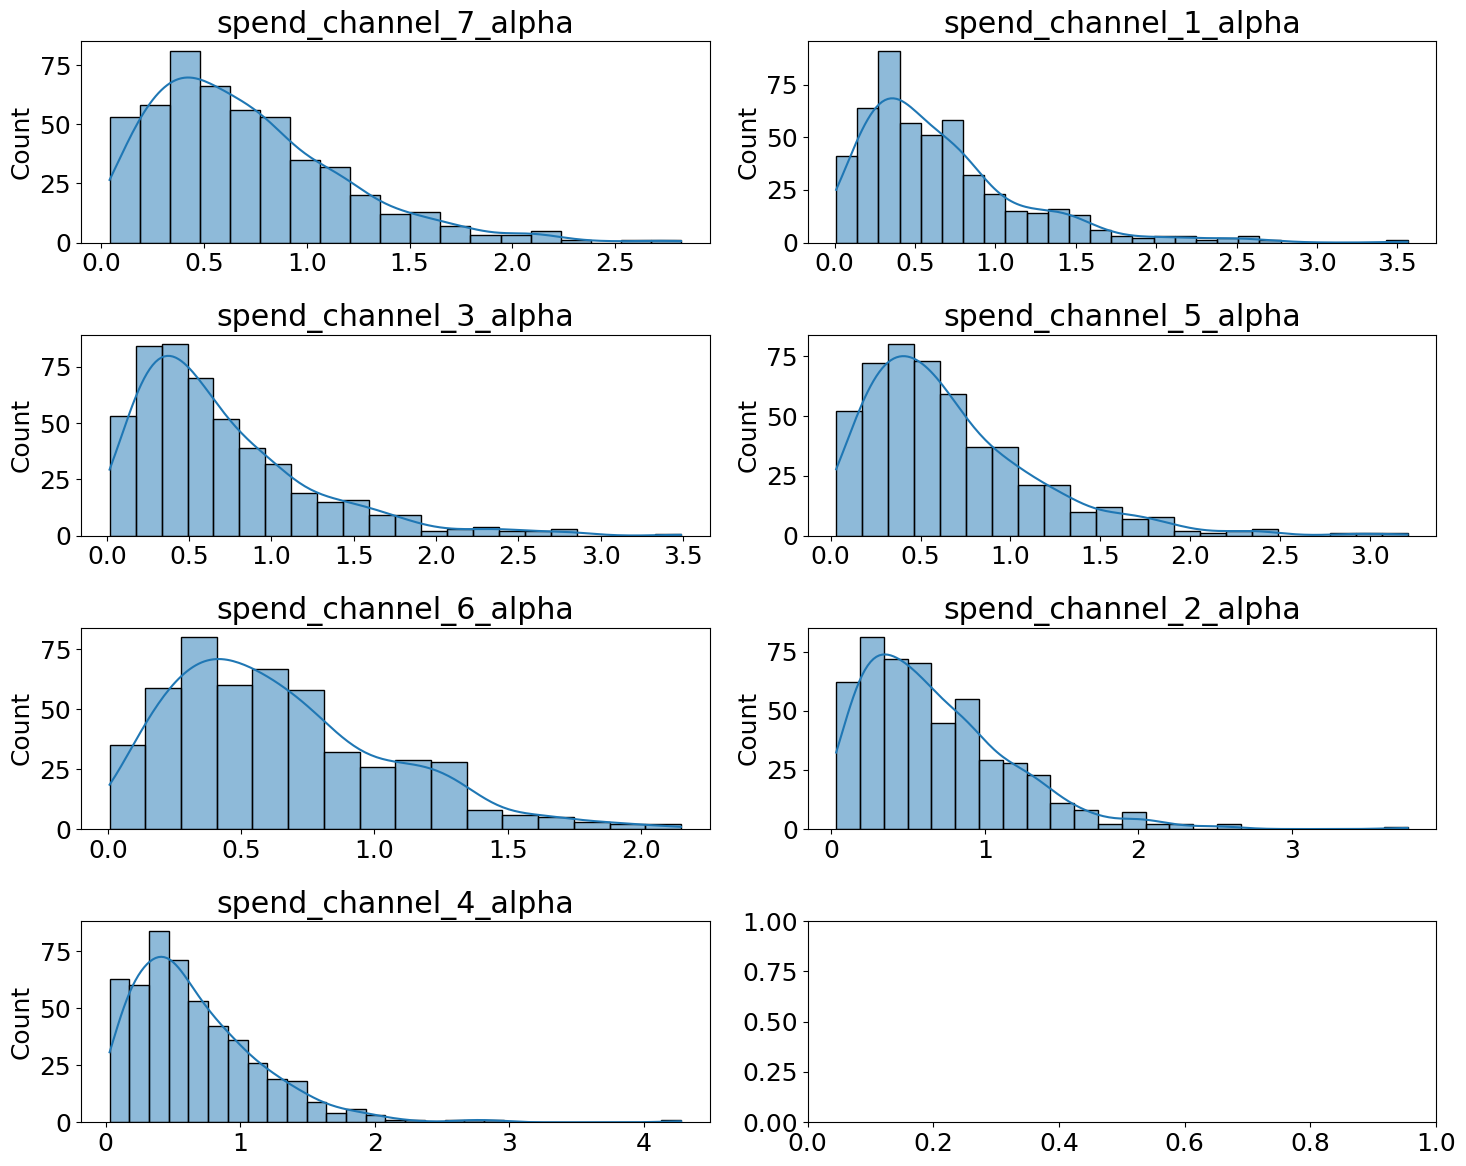

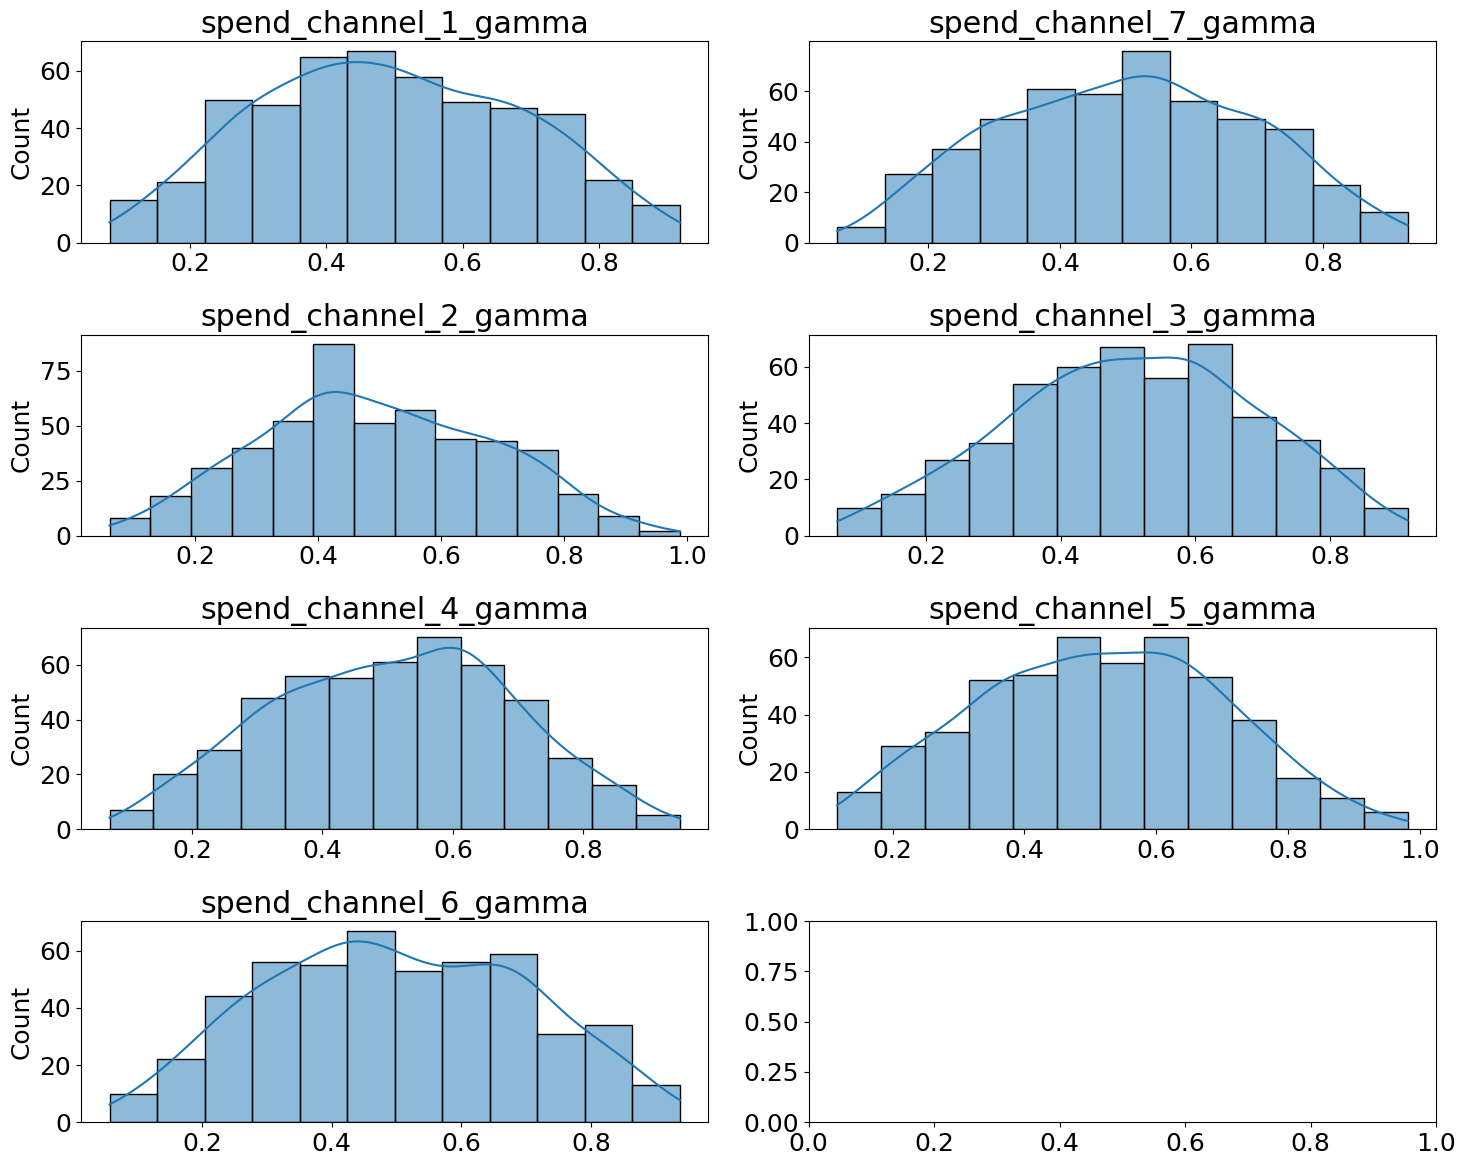

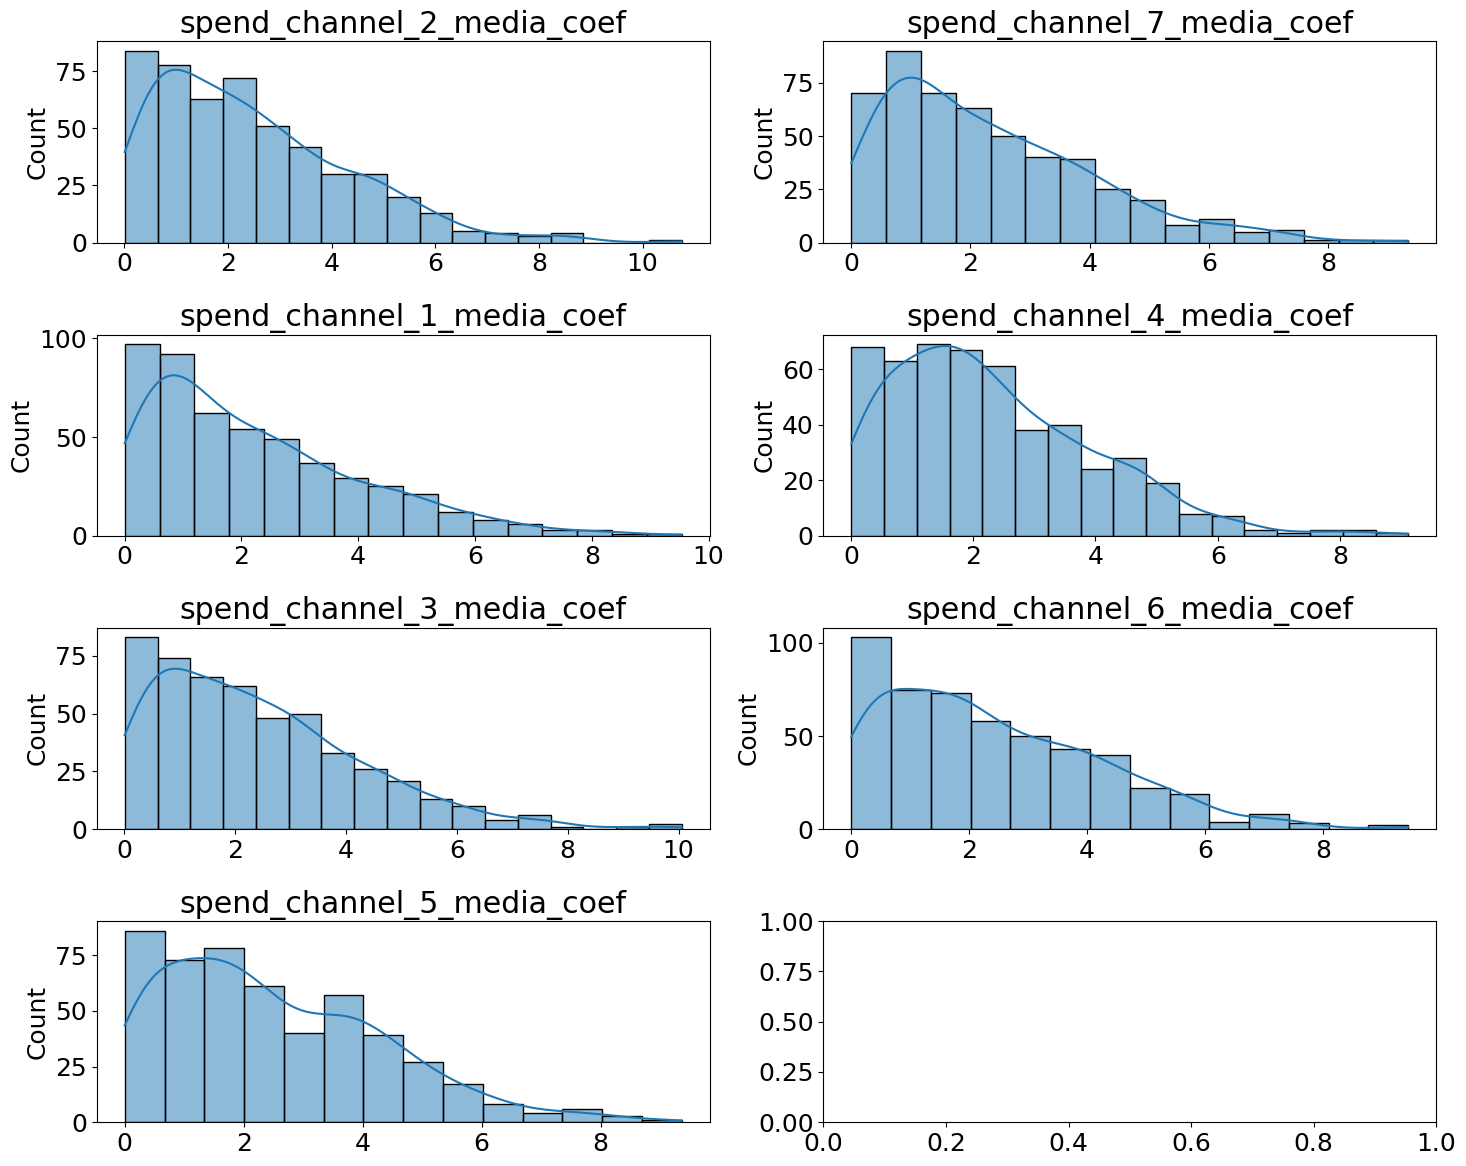

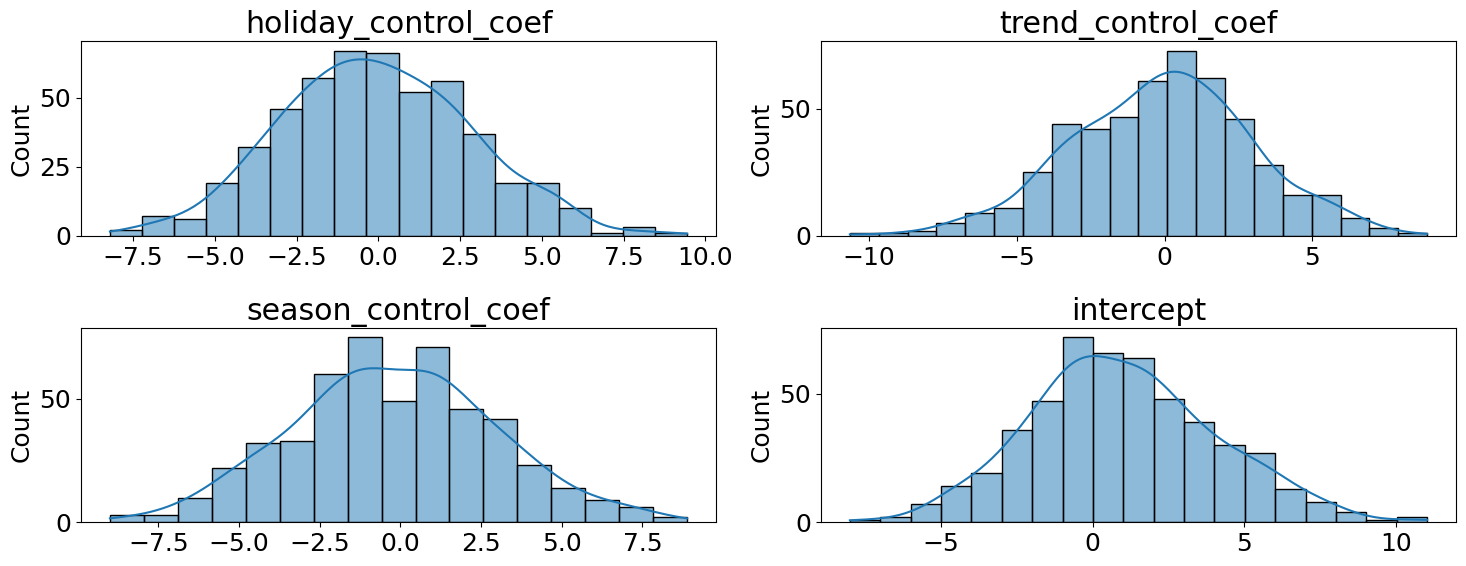

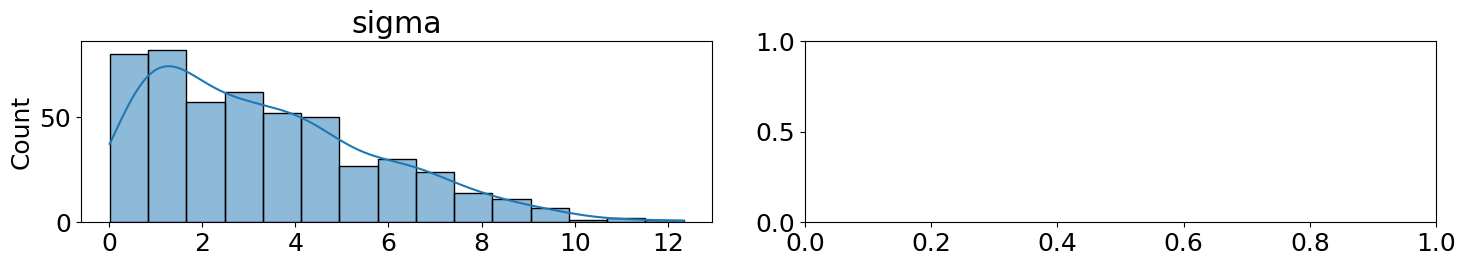

In [149]:
adstock_priors = [p for p in prior_names if p.endswith("adstock")]
plot_priors(adstock_priors, prior_pred)
print(f"adstock priors: {len(adstock_priors)}")

alpha_priors = [p for p in prior_names if p.endswith("alpha")]
plot_priors(alpha_priors, prior_pred)
print(f"alpha priors: {len(alpha_priors)}")

gamma_priors = [p for p in prior_names if p.endswith("gamma")]
plot_priors(gamma_priors, prior_pred)
print(f"gamma priors: {len(gamma_priors)}")


media_coef_priors = [p for p in prior_names if p.endswith("media_coef")]
plot_priors(media_coef_priors, prior_pred)
print(f"media coef priors: {len(media_coef_priors)}")

control_coef_priors = [p for p in prior_names if p.endswith("control_coef")] + ["intercept"]
plot_priors(control_coef_priors, prior_pred)
print(f"control coef priors: {len(control_coef_priors)}")

plot_priors(["sigma"], prior_pred)
print(f"sigma prior: 1")

In [150]:
with model_2:
    trace = pm.sample(1000, tune=1000, step=None, target_accept = 0.95, return_inferencedata=True)
    trace_summary = az.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, holiday_control_coef, season_control_coef, trend_control_coef, spend_channel_7_media_coef, spend_channel_7_alpha, spend_channel_7_gamma, spend_channel_7_adstock, spend_channel_6_media_coef, spend_channel_6_alpha, spend_channel_6_gamma, spend_channel_6_adstock, spend_channel_5_media_coef, spend_channel_5_alpha, spend_channel_5_gamma, spend_channel_5_adstock, spend_channel_4_media_coef, spend_channel_4_alpha, spend_channel_4_gamma, spend_channel_4_adstock, spend_channel_3_media_coef, spend_channel_3_alpha, spend_channel_3_gamma, spend_channel_3_adstock, spend_channel_2_media_coef, spend_channel_2_alpha, spend_channel_2_gamma, spend_channel_2_adstock, spend_channel_1_media_coef, spend_channel_1_alpha, spend_channel_1_gamma, spend_channel_1_adstock]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9092 seconds.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.


NameError: name 'az' is not defined

In [152]:
with model_2:
    trace_summary = az.summary(trace)

In [153]:
trace_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
trend_control_coef,0.53400,0.25200,0.07500,1.02000,0.00500,0.00300,3151.00000,2619.00000,1.00000
season_control_coef,0.76900,0.17200,0.45400,1.10000,0.00200,0.00200,4872.00000,3243.00000,1.00000
holiday_control_coef,0.09600,0.28000,-0.41900,0.64000,0.00400,0.00400,5216.00000,3049.00000,1.00000
intercept,-1.56500,0.80200,-3.09300,-0.29700,0.02200,0.01600,1529.00000,1771.00000,1.00000
spend_channel_1_adstock,0.51400,0.17100,0.18400,0.81500,0.00200,0.00200,6231.00000,2429.00000,1.00000
spend_channel_1_gamma,0.51200,0.19400,0.16300,0.85600,0.00300,0.00200,5331.00000,2696.00000,1.00000
spend_channel_1_alpha,0.46100,0.41100,0.00500,1.22800,0.00600,0.00500,3640.00000,1886.00000,1.00000
spend_channel_1_media_coef,0.26500,0.38000,0.00000,0.85500,0.00900,0.00600,2511.00000,2335.00000,1.00000
spend_channel_2_adstock,0.45300,0.16600,0.15500,0.75400,0.00200,0.00200,5962.00000,2773.00000,1.00000
spend_channel_2_gamma,0.53300,0.18700,0.20900,0.88900,0.00300,0.00200,4809.00000,2708.00000,1.00000


In [154]:
with model_2:
    ppc_all = pm.sample_posterior_predictive(
        trace, var_names=["outcome"] + list(trace_summary.index), random_seed=42
    )

<Axes: xlabel='outcome / outcome'>

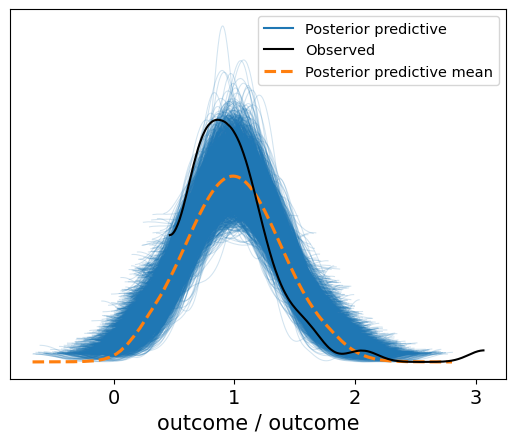

In [155]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc_all, model=model_2), var_names = ["outcome"])

In [156]:
# measure the prediction error is a normalized root-mean-square error (NRMSE).
def nrmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2)) / (np.max(y_true) - np.min(y_true))

In [157]:
trace_summary = az.summary(trace)
trace_summary = trace_summary.rename(columns={'mean': 'old_mean'})
trace_summary["mean"] = np.inf


for variable in list(trace_summary.index):
    #mean_variable = ppc_all[variable].mean()
    mean_variable = trace.posterior[variable].mean(axis = 0).mean().values
    trace_summary.loc[trace_summary.index == variable, "mean"] = mean_variable
	
	
y_true = data[target].values
y_pred = ppc_all["outcome"].mean(axis = 0) * data[target].mean()

print(f"RMSE: {np.sqrt(np.mean((y_true - y_pred)**2))}")
print(f"MAPE: {np.mean(np.abs((y_true - y_pred) / y_true))}")
print(f"NRMSE: {nrmse(y_true, y_pred)}")

RMSE: 35658.01754263525
MAPE: 0.1939809279480482
NRMSE: 0.1004509799505071


#### The predicted revenue is the average of posterior samples multiplied by average of the target column

### Residual

In [163]:
def plot_residuals(actual_vs_predicted: pd.DataFrame, figure_size = (15, 10)):
    """Residual plot

    Args:
        actual_vs_predicted (pd.DataFrame): Data Frame with three columns: date, actual, predicted
        figure_size (tuple, optional): Figure size. Defaults to (15, 10).
    """
    
    plt = ggplot(actual_vs_predicted, aes("predicted", y = "actual - predicted"))\
    + geom_point(size = 2, show_legend = True)\
    + geom_hline(yintercept = 0, linetype = "dashed")\
    + geom_smooth(se=True, method = "loess", color = "blue")\
    + ggtitle("Actuals vs. predicted response") + xlab("predicted") + ylab("residual")\
    + theme(figure_size = figure_size,
                        legend_direction='horizontal', 
                        legend_position= "bottom",
                        legend_box_spacing=0.5,
                        legend_key_size=20, 
                        legend_entry_spacing_y=10, 
                        axis_text_y=element_text(weight="bold", size = 10)
        ) 
    
    return plt

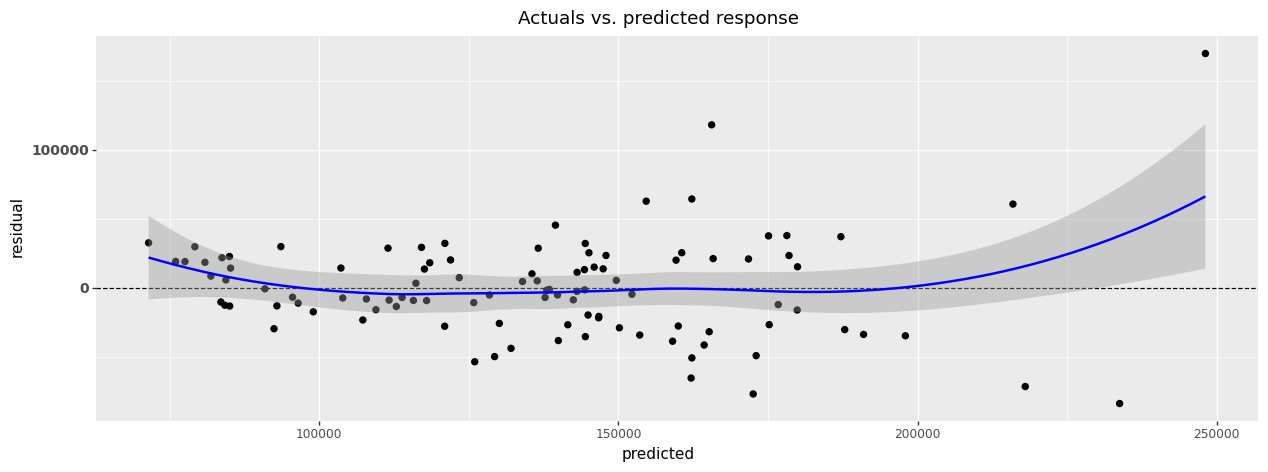

In [164]:
plot = plot_residuals(pd.DataFrame({"actual": y_true, "predicted": y_pred}), figure_size = (15, 5))
print(plot)

In [165]:
adstock_params = trace_summary[trace_summary.index.str.contains("adstock")][["mean", "sd"]].reset_index().rename(columns = {'index': 'name'}).assign(name = lambda x: x["name"].str.replace("_adstock", ""))
saturation_params = pd.merge(
    trace_summary[trace_summary.index.str.contains("gamma")][["mean"]].reset_index().rename(columns = {'mean': 'gamma'}).assign(name = lambda x: x["index"].str.replace("_gamma", "")), 
    trace_summary[trace_summary.index.str.contains("alpha")][["mean"]].reset_index().rename(columns = {'mean': 'alpha'}).assign(name = lambda x: x["index"].str.replace("_alpha", "")), on = "name" )
control_coefficients = trace_summary[trace_summary.index.str.contains("_control_coef")][["mean", "sd"]].reset_index().assign(name = lambda x: x["index"].str.replace("_control_coef", ""))
delay_coefficients = trace_summary[trace_summary.index.str.contains("_media_coef")][["mean", "sd"]].reset_index().assign(name = lambda x: x["index"].str.replace("_media_coef", ""))

In [167]:
data_transformed_decomposed = data1.copy()
intercept = trace_summary[trace_summary.index == "intercept"]["mean"].iloc[0]
data_transformed_decomposed["intercept"] = intercept
print(f"Intercept: {intercept}")

for delay_channel in delay_channels:
    print(delay_channel)
    
    adstock = adstock_params[adstock_params.name == delay_channel]
    adstock_theta = adstock["mean"].iloc[0]
    
    print(f"\tadstock {adstock_theta} transformation")
    
    data_transformed_decomposed[delay_channel] = adstock_geometric(data_transformed_decomposed[delay_channel].values,  adstock_theta)
    
    saturation = saturation_params[saturation_params.name == delay_channel]
    
    saturation_alpha = saturation["alpha"].iloc[0]
    saturation_gamma = saturation["gamma"].iloc[0]
    
    print(f"\tsaturation alpha {saturation_alpha}, gamma {saturation_gamma} transformation")
    
    #use the unbound version of saturation
    data_transformed_decomposed[delay_channel] = saturation_hill_pymc3(data_transformed_decomposed[delay_channel].values, alpha = saturation_alpha, gamma = saturation_gamma)
    
    coefs = delay_coefficients[delay_coefficients.name == delay_channel]
    coef = coefs["mean"].iloc[0]
    
    data_transformed_decomposed[delay_channel] = data_transformed_decomposed[delay_channel] * coef
    print(f"\tcoefficient: {coef}")
    
#apply coefficients

for variable in control_variables:
    coefs = control_coefficients[control_coefficients.name == variable]
    coef = coefs["mean"].iloc[0]
    print(f"Control Coefficient: {variable}: {coef}")
    data_transformed_decomposed[variable] = data_transformed_decomposed[variable] * coef

Intercept: -1.565326635133605
spend_channel_1
	adstock 0.513599929137085 transformation
	saturation alpha 0.46058395042514505, gamma 0.5120864894810246 transformation
	coefficient: 0.2652899551787317
spend_channel_2
	adstock 0.4526488504917534 transformation
	saturation alpha 0.5908797072047655, gamma 0.5334964829256356 transformation
	coefficient: 0.7492525578148991
spend_channel_3
	adstock 0.39674031045690045 transformation
	saturation alpha 0.5648248931160963, gamma 0.5250472104881745 transformation
	coefficient: 0.9829358390474127
spend_channel_4
	adstock 0.4766312174843454 transformation
	saturation alpha 0.45358323772816184, gamma 0.5106532633820382 transformation
	coefficient: 0.3958849611641425
spend_channel_5
	adstock 0.46324533211226643 transformation
	saturation alpha 0.4688025317590657, gamma 0.5105525237265038 transformation
	coefficient: 0.5245796957120008
spend_channel_6
	adstock 0.5051889450339316 transformation
	saturation alpha 0.6713028142008475, gamma 0.522101011180

RMSE: 43153.935061273805
MAPE: 0.25287666070080933
NRMSE: 0.1004509799505071


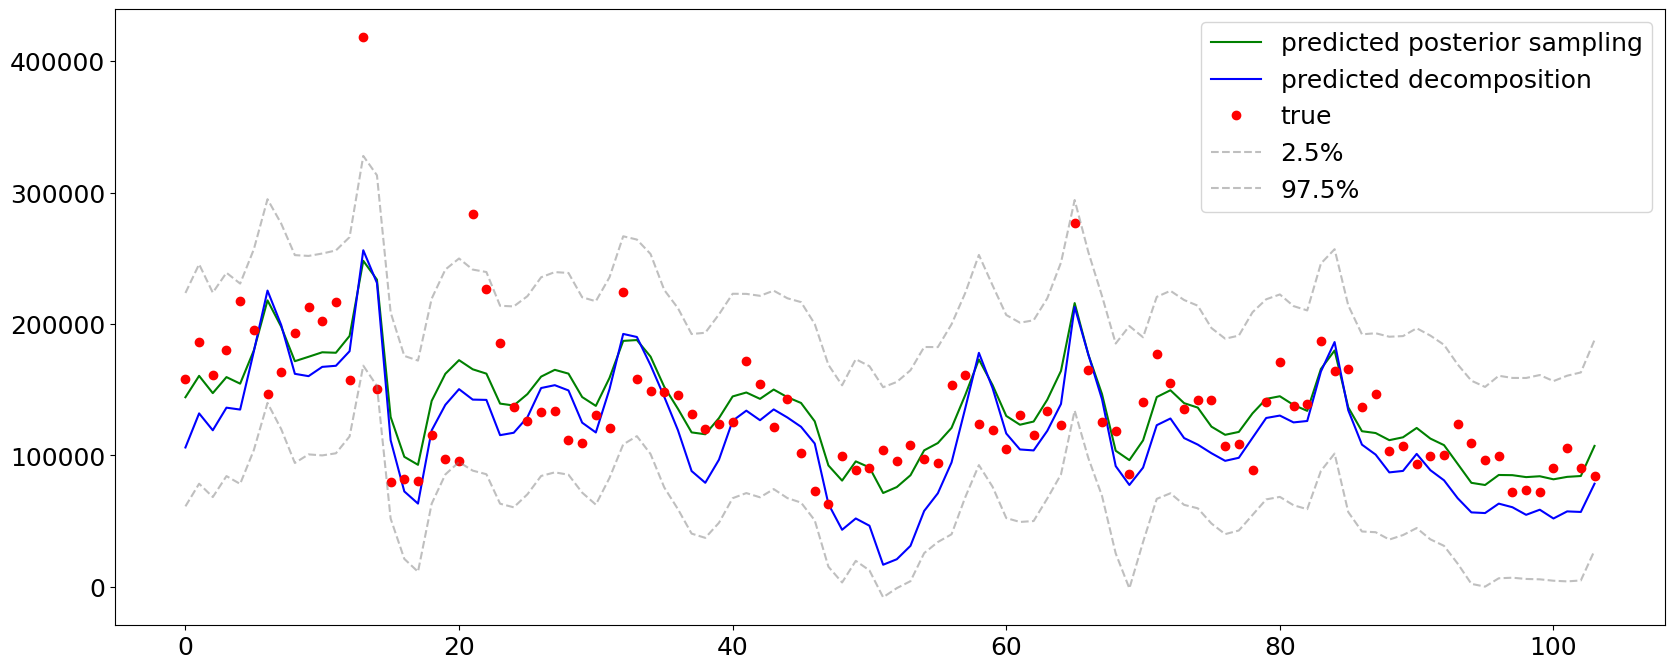

In [186]:
data_transformed_decomposed["prediction"] = data_transformed_decomposed[delay_channels + control_variables + ["intercept"]].sum(axis = 1)
y_pred_decomposed = data_transformed_decomposed["prediction"]* data[target].mean()


print(f"RMSE: {np.sqrt(np.mean((y_true - y_pred_decomposed)**2))}")
print(f"MAPE: {np.mean(np.abs((y_true - y_pred_decomposed) / y_true))}")
print(f"NRMSE: {nrmse(y_true, y_pred)}")
qs = mquantiles(data[target].mean() * (ppc_all["outcome"]), [0.025, 0.975], axis=0)
qs_decomposed = mquantiles(data[target].mean() * (ppc_all["outcome"]), [0.025, 0.975], axis=0)
fig, ax = plt.subplots(figsize = (20, 8))
_ = ax.plot((ppc_all["outcome"].mean(axis = 0) * data[target].mean()), color = "green", label = "predicted posterior sampling")
_ = ax.plot(y_pred_decomposed, color = "blue", label = "predicted decomposition")
_ = ax.plot(data[target].values, 'ro', label = "true")
_ = ax.plot(qs[0], '--', color = "grey", label = "2.5%", alpha = 0.5)
_ = ax.plot(qs[1], '--', color = "grey", label = "97.5%", alpha = 0.5)
_ = ax.legend()

In [189]:
spend_df = pd.DataFrame()
media_spend_exposure_df=pd.DataFrame(columns = ['exposure'])
for media_channel in media_channels:
    temp_series = data[media_channel].values
    #exposure to spend should
    if len(media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]) > 0:
        
        vmax = media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]["V_max"].iloc[0]
        km = media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]["K_m"].iloc[0]
        spends = exposure_to_spend_menten_func(temp_series, V_max = vmax, K_m = km)
        spends_total = spends.sum()
    else:
        spends_total = temp_series.sum()
        
    spend_df = pd.concat([spend_df, pd.DataFrame({'media': [media_channel], 'total_spend': [spends_total]})]).reset_index(drop=True)

spend_df["spend_share"] = spend_df["total_spend"] / spend_df["total_spend"].sum()
spend_df

,media,total_spend,spend_share
0,spend_channel_1,129542.90000,0.01796
1,spend_channel_2,35738.66000,0.00496
2,spend_channel_3,2028746.51000,0.28128
3,spend_channel_4,719174.22000,0.09971
4,spend_channel_5,891863.59000,0.12365
5,spend_channel_6,526624.70000,0.07301
6,spend_channel_7,2880942.21000,0.39943


In [191]:
response_df = pd.DataFrame()
for media_channel in media_channels:
    response = data_transformed_decomposed[media_channel].values
    response_total = response.sum()
    
    response_df = pd.concat([response_df, pd.DataFrame({'media': [media_channel], 'total_effect': [response_total]})]).reset_index(drop=True)
response_df["effect_share"] = response_df["total_effect"] / response_df["total_effect"].sum()

response_df

,media,total_effect,effect_share
0,spend_channel_1,10.30807,0.05414
1,spend_channel_2,31.46202,0.16524
2,spend_channel_3,48.76327,0.25611
3,spend_channel_4,17.51168,0.09197
4,spend_channel_5,23.68290,0.12438
5,spend_channel_6,13.83085,0.07264
6,spend_channel_7,44.84180,0.23551


In [192]:
spend_response_share_df = pd.concat([spend_df, response_df.drop(columns=["media"])], axis = 1)
spend_response_share_df

,media,total_spend,spend_share,total_effect,effect_share
0,spend_channel_1,129542.90000,0.01796,10.30807,0.05414
1,spend_channel_2,35738.66000,0.00496,31.46202,0.16524
2,spend_channel_3,2028746.51000,0.28128,48.76327,0.25611
3,spend_channel_4,719174.22000,0.09971,17.51168,0.09197
4,spend_channel_5,891863.59000,0.12365,23.68290,0.12438
5,spend_channel_6,526624.70000,0.07301,13.83085,0.07264
6,spend_channel_7,2880942.21000,0.39943,44.84180,0.23551


In [194]:
def plot_spend_vs_effect_share(decomp_spend: pd.DataFrame, figure_size = (15, 10)):
    
    plot_spend_effect_share = decomp_spend.melt(id_vars = ["media"], value_vars = ["spend_share", "effect_share"])

    plt = ggplot(plot_spend_effect_share, aes("media", "value", fill = "variable")) \
    + geom_bar(stat = "identity", position = "dodge") \
    + geom_text(aes(label = "value * 100", group = "variable"), color = "darkblue", position=position_dodge(width = 0.5), format_string = "{:.2f}%") \
    + coord_flip() \
    + ggtitle("Share of Spend VS Share of Effect") + ylab("") + xlab("") \
    + theme(figure_size = figure_size, 
                    legend_direction='vertical', 
                    legend_title=element_blank(),
                    legend_key_size=20, 
                    legend_entry_spacing_y=5) 
    return plt

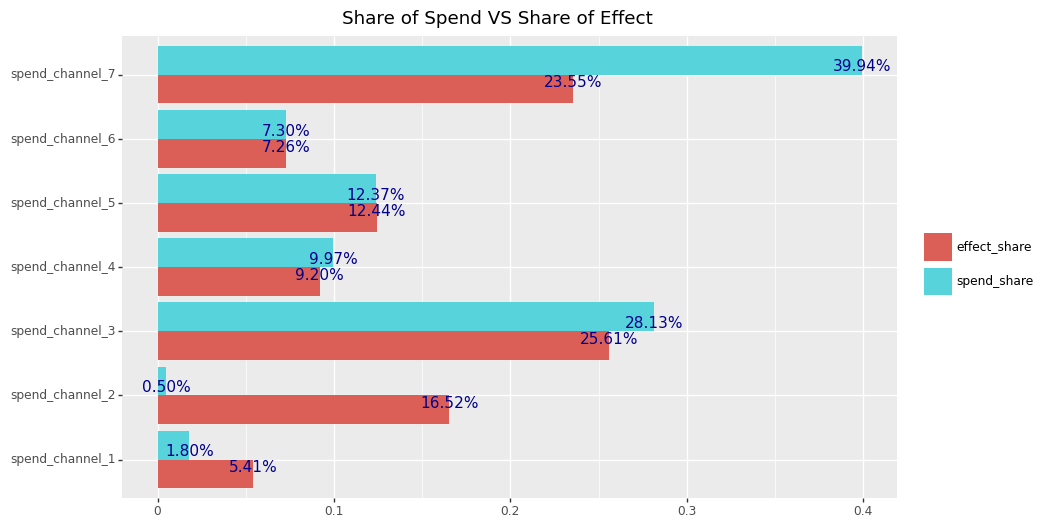

<ggplot: (152112827296)>

In [196]:
plot_spend_vs_effect_share(spend_response_share_df, figure_size = (10, 6))